In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
# from plotnine import *
from pyecharts.charts import Map
from pyecharts import options
%matplotlib inline
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

In [2]:
df = pd.read_excel('../../data/爬取的数据.xlsx', sheet_name='非二手帆船')
df.head()

,Basics.Year,Basics.Make,Basics.Model,Basics.Class,Basics.Length,Basics.FuelType,Basics.HullMaterial,Basics.OfferedBy,Propulsion.EngineMake,Propulsion.TotalPower,...,Features.OutsideEquipment.WindGenerator,Features.InsideEquipment.Seakeeper,Features.InsideEquipment.AirCompressor,Features.InsideEquipment.ChemicalHead,Specifications.Miscellaneous.LiferaftCapacity,Features.Rigging.HydraulicWinch,Propulsion.RopeCutter,Specifications.Miscellaneous.DeadriseAtTransom,Features.AdditionalEquipment.LaunchingTrailer,Features.AdditionalEquipment.BeachingLegs
0,2023,Beneteau,Oceanis 46.1 - In Stock,Cruiser,46ft,Diesel,Fiberglass,"Cape Yachts at South Wharf - South Dartmouth, MA",yanmar,57hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,Jeanneau,Sun Odyssey 440,Cruiser,44ft,Diesel,Fiberglass,Marine Servicenter - San Diego,Yanmar,57hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,Jeanneau,Sun Odyssey 490,Cruiser,49ft,Diesel,Fiberglass,Marine Servicenter - Seattle,Yanmar,80hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023,Jeanneau,60,Cruiser,60ft,Diesel,Fiberglass,Marine Servicenter - San Diego,Yanmar,150hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,Jeanneau,Yacht 65,Cruiser,65ft,Diesel,Fiberglass,Marine Servicenter - Seattle,Volvo,180hp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info() # 有113个 object需要处理。  一共2188个条目。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2188 entries, 0 to 2187
Columns: 124 entries, Basics.Year to Features.AdditionalEquipment.BeachingLegs
dtypes: float64(10), int64(1), object(113)
memory usage: 2.1+ MB


In [3]:
df.columns # 太多了，分开处理 124
basics_columns = list(filter(lambda x:x.startswith('Basics'), df.columns))
propulsion_columns = list(filter(lambda x:x.startswith('Propulsion'), df.columns))
specification_columns = list(filter(lambda x:x.startswith('Specification'), df.columns))
feature_columns = list(filter(lambda x:x.startswith('Feature'), df.columns))

list(map(len, (basics_columns, propulsion_columns, specification_columns, feature_columns)))
price_column = ['Price']
df[price_column].describe()

,Price
count,1.163000e+03
mean,7.395047e+05
std,1.664770e+06
min,2.144000e+03
25%,1.412770e+05
50%,3.649000e+05
75%,6.918905e+05
max,2.450000e+07


## 针对 Basics进行处理

In [4]:
appropriate_types = {'定类':str, '定序':int, '定距':float, '定比':float}
appropriate_operation = {'定类':'mod', '定序':'median', '定距':'mean', '定比':'mean'}

In [5]:
should_be = ['定距', '定类', '定类', '定类', '定比', '定类', '定类', '定类', '定类', '定比']
should_be = list(map(lambda x: appropriate_types[x], should_be))
basics_columns, should_be

(['Basics.Year',
  'Basics.Make',
  'Basics.Model',
  'Basics.Class',
  'Basics.Length',
  'Basics.FuelType',
  'Basics.HullMaterial',
  'Basics.OfferedBy',
  'Basics.HullShape',
  'Basics.HullWarranty'],
 [float, str, str, str, float, str, str, str, str, float])

In [6]:
def len_tran(x):
    assert x.endswith('ft')
    return float(x[:-2])
df['Basics.Length'] = df['Basics.Length'].map(len_tran)

In [9]:
df[['Basics.Length', 'Basics.HullWarranty']].tail()

,Basics.Length,Basics.HullWarranty
2183,40.52,0.0
2184,39.08,0.0
2185,38.00,0.0
2186,37.00,0.0
2187,14.00,0.0


In [8]:
def war_tran(x):
    x = str(x)
    if x=='nan':
        # return x
        return 0 # 用0填充保险值。
    num = x.split(' ')[0]
    return float(num)
df['Basics.HullWarranty'] = df['Basics.HullWarranty'].map(war_tran)

In [10]:
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].value_counts()

Basics.Model     Basics.FuelType  Basics.HullShape
Sun Odyssey 410  Diesel           Monohull            24
Sun Odyssey 440  Diesel           Monohull            22
Sun Odyssey 490  Diesel           Monohull            13
Sun Odyssey 380  Diesel           Monohull            13
34               Diesel           Monohull            12
                                                      ..
52F              Diesel           Catamaran            1
52LC             Diesel           Monohull             1
530              Diesel           Monohull             1
530 Grand Large  Diesel           Monohull             1
xp44             Diesel           Monohull             1
Length: 342, dtype: int64

In [11]:
# df[df['Basics.Model'].isnull()]
# df['Basics.Model'] = df['Basics.Model'].dropna()
df = df.dropna(subset=['Basics.Model']) # dropna是一个整体操作

In [11]:
# df['Make-Model'] = df['Basics.Make'] + '-' + df['Basics.Model']
group = df.groupby(['Basics.Make', 'Basics.Model'])


In [12]:
datalen = []
for k, v in group:
    # print(k)
    # print(len(v))
    datalen.append(len(v))
    # print(v['Basics.HullShape'].value_counts())
    # print()
# plt.hist(datalen, bins=30)

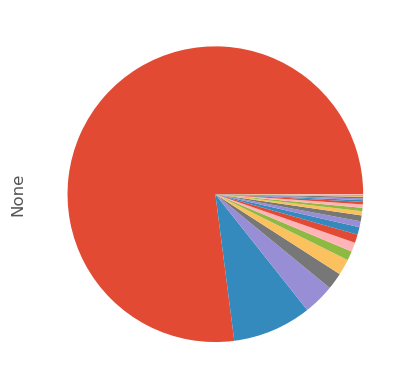

In [14]:
pd.Series(datalen).astype(str).value_counts().plot.pie()

plt.savefig('make-model.png')

In [15]:
cols = ['Basics.FuelType', 'Basics.HullShape']

for k, v in group:
    if len(v)>=5:
        # 使用组内操作
        for col in cols:
            # df[col] = df[col].fillna(df[col].mode())
            v[col].fillna(v[col].mode(), inplace=True)
    else:
        # 使用整个列表的填充
        for col in cols:
            # df[col] = df[col].fillna(df[col].mode())
            v[col].fillna(df[col].mode(), inplace=True)
    

In [ ]:
# # if df[col].isnull().sum()==len(v):
            # #     raise
            # # df[col] = df[col].fillna(v[col].mode())
            # v[col].fillna(v[col].mode(), inplace=True)
            # 想把v内缺失的值填充为组内的众数，但是为什么没能修改原来的df呢？
            # v[col] = v[col].fillna(v[col].mode())

In [25]:
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].tail()

,Basics.Model,Basics.FuelType,Basics.HullShape
2183,55,Diesel,NaN
2184,Isla 40,Diesel,NaN
2185,CATSMART,Diesel,NaN
2186,Hood Blackwatch,Diesel,NaN
2187,First 14,Other,NaN


In [24]:
df[basics_columns].isnull().sum()

Basics.Year               0
Basics.Make               0
Basics.Model              0
Basics.Class              0
Basics.Length             0
Basics.FuelType          41
Basics.HullMaterial       0
Basics.OfferedBy          0
Basics.HullShape       1475
Basics.HullWarranty       0
dtype: int64

In [53]:
# for col, typ in zip(basics_columns, should_be):
#     df[col] = df[col].astype(typ)

In [54]:
# df[basics_columns].dtypes

Basics.Year            float64
Basics.Make             object
Basics.Model            object
Basics.Class            object
Basics.Length          float64
Basics.FuelType         object
Basics.HullMaterial     object
Basics.OfferedBy        object
Basics.HullShape        object
Basics.HullWarranty    float64
dtype: object

Basics.Year               0
Basics.Make               0
Basics.Model              5
Basics.Class              0
Basics.Length             0
Basics.FuelType          41
Basics.HullMaterial       0
Basics.OfferedBy          0
Basics.HullShape       1481
Basics.HullWarranty       0
dtype: int64

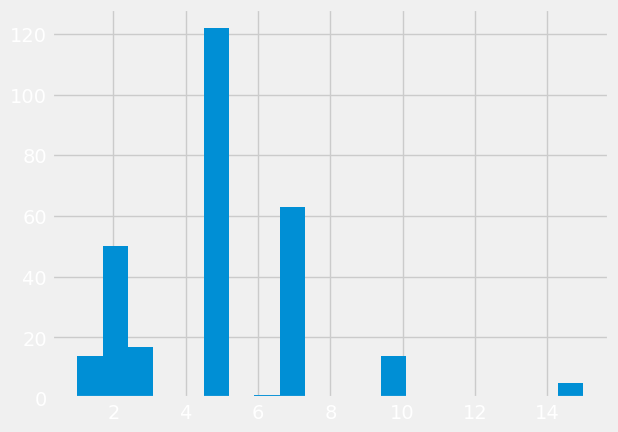

In [19]:
plt.hist(df['Basics.HullWarranty'].dropna(), bins=20)
plt.savefig('hull_warranty.png')

## 针对propulsion进行处理

In [24]:
should_be = ['定类', '定比', '定类', '定类', '定类', '定距', '定比', '定类', '定序', '定类', '定序', '定序']
should_be = list(map(lambda x: appropriate_types[x], should_be))
assert len(propulsion_columns) == len(should_be)
propulsion_columns, should_be

(['Propulsion.EngineMake',
  'Propulsion.TotalPower',
  'Propulsion.EngineType',
  'Propulsion.FuelType',
  'Propulsion.EngineModel',
  'Propulsion.EngineYear',
  'Propulsion.EngineHours',
  'Propulsion.DriveType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'],
 [str, float, str, str, str, float, float, str, int, str, int, int])

In [ ]:
def tran(x):
    if isinstance(x, float):
        return np.nan
    assert x.endswith('hp')
    return float(x[:-2])
df['Propulsion.TotalPower'] = df['Propulsion.TotalPower'].apply(tran).astype(float)
df['Propulsion.TotalPower'].head(2)

0    57.0
1    57.0
Name: Propulsion.TotalPower, dtype: float64

In [ ]:
df[propulsion_columns].head()

,Propulsion.EngineMake,Propulsion.TotalPower,Propulsion.EngineType,Propulsion.FuelType,Propulsion.EngineModel,Propulsion.EngineYear,Propulsion.EngineHours,Propulsion.DriveType,Propulsion.PropellerType,Propulsion.PropellerMaterial,Propulsion.FoldingPropeller,Propulsion.RopeCutter
0,yanmar,57.0,Inboard,Diesel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yanmar,57.0,Inboard,Diesel,4JH57CR,2022.0,2.0,Direct Drive,3 Blade,NaN,NaN,NaN
2,Yanmar,80.0,Inboard,Diesel,4JH80CR,2022.0,10.0,Sail Drive,3 Blade,NaN,NaN,NaN
3,Yanmar,150.0,Inboard,Diesel,LA 4LV150CR,2022.0,2.0,Direct Drive,3 Blade,Bronze,NaN,NaN
4,Volvo,180.0,Inboard,Diesel,D4,2022.0,NaN,Direct Drive,3 Blade,Bronze,✓,NaN


In [16]:
def tran(x):
    if isinstance(x, float):
        return np.nan
    if x.endswith(' blades'):
        return x[:-7]
    if 'folding' in x:
        return np.nan
    return np.nan
col = 'Propulsion.PropellerType'
df[col].head()
tran('2 blades')
df[col].map(tran)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2183   NaN
2184   NaN
2185   NaN
2186   NaN
2187   NaN
Name: Propulsion.PropellerType, Length: 2188, dtype: float64

In [ ]:
df[col] = df[col].map(tran)
# 定序类型的数据，应当使用中位数填充
# df[col] = df[col].fillna(df[col].median(), inplace=True) 
df[col].head(5)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Propulsion.PropellerType, dtype: float64

In [23]:
df[propulsion_columns].dtypes
df[propulsion_columns].isnull().count()

Propulsion.EngineMake           2188
Propulsion.TotalPower           2188
Propulsion.EngineType           2188
Propulsion.FuelType             2188
Propulsion.EngineModel          2188
Propulsion.EngineYear           2188
Propulsion.EngineHours          2188
Propulsion.DriveType            2188
Propulsion.PropellerType        2188
Propulsion.PropellerMaterial    2188
Propulsion.FoldingPropeller     2188
Propulsion.RopeCutter           2188
dtype: int64